<a href="https://colab.research.google.com/github/naimurborno/Generative_Ai/blob/main/Style_Transfer_using_VGG_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
import cv2
from IPython.display import Image, clear_output
import numpy as np
from keras import backend as K

from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image, clear_output

In [6]:
IMAGE_DIR = 'images'

# create directory
!mkdir {IMAGE_DIR}

# download images to the directory you just created
!wget -q -O ./images/cafe.jpg https://cdn.pixabay.com/photo/2018/07/14/15/27/cafe-3537801_1280.jpg
!wget -q -O ./images/swan.jpg https://cdn.pixabay.com/photo/2017/02/28/23/00/swan-2107052_1280.jpg
!wget -q -O ./images/tnj.jpg https://i.dawn.com/large/2019/10/5db6a03a4c7e3.jpg
!wget -q -O ./images/rudolph.jpg https://cdn.pixabay.com/photo/2015/09/22/12/21/rudolph-951494_1280.jpg
!wget -q -O ./images/dynamite.jpg https://cdn.pixabay.com/photo/2015/10/13/02/59/animals-985500_1280.jpg
!wget -q -O ./images/painting.jpg https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg

print("image files you can choose from: ")
!ls images

mkdir: cannot create directory ‘images’: File exists
image files you can choose from: 
cafe.jpg  dynamite.jpg	painting.jpg  rudolph.jpg  swan.jpg  tnj.jpg


In [7]:
content_path = '/content/images/swan.jpg'
style_path = '/content/images/rudolph.jpg'

In [8]:
def tensor_to_image(tensor):
  '''converts a tensor to an image'''
  tensor_shape = tf.shape(tensor)
  number_elem_shape = tf.shape(tensor_shape)
  if number_elem_shape > 3:
    assert tensor_shape[0] == 1
    tensor = tensor[0]
  return tf.keras.preprocessing.image.array_to_img(tensor)


def load_img(path_to_img):
  '''loads an image as a tensor and scales it to 512 pixels'''
  max_dim = 512
  image = tf.io.read_file(path_to_img)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)

  shape = tf.shape(image)[:-1]
  shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis, :]
  image = tf.image.convert_image_dtype(image, tf.uint8)

  return image


def load_images(content_path, style_path):
  '''loads the content and path images as tensors'''
  content_image = load_img("{}".format(content_path))
  style_image = load_img("{}".format(style_path))

  return content_image, style_image


def imshow(image, title=None):
  '''displays an image with a corresponding title'''
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)


def show_images_with_objects(images, titles=[]):
  '''displays a row of images with corresponding titles'''
  if len(images) != len(titles):
    return

  plt.figure(figsize=(20, 12))
  for idx, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, len(images), idx + 1)
    plt.xticks([])
    plt.yticks([])
    imshow(image, title)


def display_gif(gif_path):
  '''displays the generated images as an animated gif'''
  with open(gif_path,'rb') as f:
    display_fn(Image(data=f.read(), format='png'))


def create_gif(gif_path, images):
  '''creates animation of generated images'''
  mimsave(gif_path, images, fps=1)

  return gif_path


def clip_image_values(image, min_value=0.0, max_value=255.0):
  '''clips the image pixel values by the given min and max'''
  return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)


def preprocess_image(image):
  '''centers the pixel values of a given image to use with VGG-19'''
  image = tf.cast(image, dtype=tf.float32)
  image = tf.keras.applications.vgg19.preprocess_input(image)

  return image

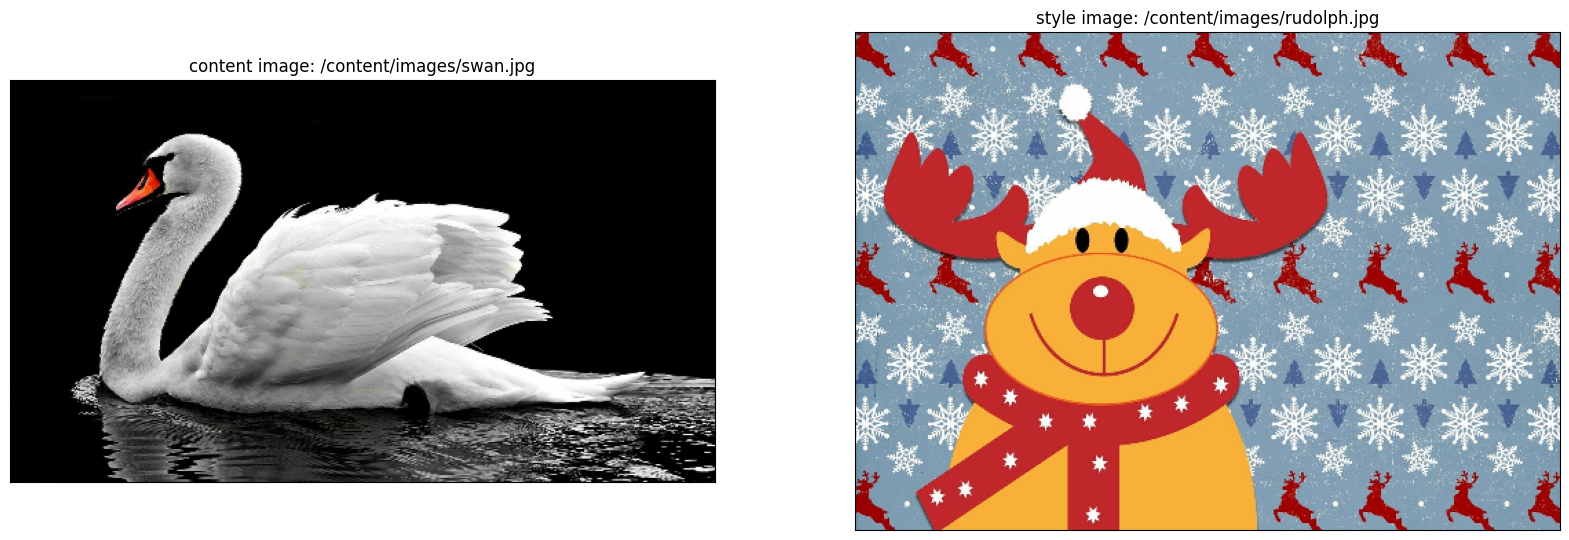

In [9]:
content_image, style_image = load_images(content_path, style_path)
show_images_with_objects([content_image, style_image],
                         titles=[f'content image: {content_path}',
                                 f'style image: {style_path}'])

In [10]:
pretrained_model=tf.keras.applications.VGG19(include_top=False,weights='imagenet')
pretrained_model.summary()

80134624/80134624 [==============================] - 3s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [11]:
style_layer=['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
content_layer=['block5_conv4']
total_layer=style_layer+content_layer
style_layer_no=len(style_layer)
content_layer_no=len(content_layer)
print(style_layer_no,content_layer_no,total_layer)

5 1 ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1', 'block5_conv4']


In [12]:
def get_model(input_layer):
  vgg=tf.keras.applications.VGG19(include_top=False,weights='imagenet')
  outputs=[vgg.get_layer(name).output for name in input_layer]
  return tf.keras.Model(inputs=vgg.input,outputs=outputs)

In [13]:
model=get_model(total_layer)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [15]:
def gram_matrix(input_tensor):
  gram=tf.linalg.einsum('bijc,bijd->bcd',input_tensor,input_tensor)
  input_shape=tf.shape(input_tensor)
  height=input_shape[1]
  width=input_shape[2]
  num_locations=tf.cast(height*width,tf.float32)
  scaled_gram=gram/num_locations
  return scaled_gram

In [16]:
def get_content_features(image):
  preprocessed_image=preprocess_image(image)
  outputs=model(preprocessed_image)
  content_output=outputs[style_layer_no:]
  return content_output

In [17]:
def get_style_features(image):
  preprocessed_image=preprocess_image(image)
  outputs=model(preprocessed_image)
  style_outputs=outputs[:style_layer_no]
  style_features=[gram_matrix(layer_name) for layer_name in style_outputs]
  return style_features

In [40]:
def get_style_loss(targets,features):
  return tf.reduce_sum(tf.square(targets-features))
def get_content_loss(targets,features):
  return 0.5*tf.reduce_sum(tf.square(targets-features))

In [41]:
def get_style_content_loss(style_targets,style_features,style_weight,content_targets,content_features,content_weight):
  style_loss=tf.add_n([get_style_loss(style_target,style_feature) for style_target,style_feature in zip(style_targets,style_features)])
  content_loss=tf.add_n(get_content_loss(content_target,content_feature) for content_target,content_feature in zip(content_targets,content_features))
  style_loss=style_loss*style_weight/style_layer_no
  content_loss=content_loss*content_weight/content_layer_no
  loss=style_loss+content_loss
  return loss

In [42]:
def calculate_gradient(image,style_targets,style_weight,content_targets,content_weight):
  with tf.GradientTape() as tape:
    style_features=get_style_features(image)
    content_features=get_content_features(image)
    loss=get_style_content_loss(style_targets,style_features,style_weight,content_targets,content_features,content_weight)
  gradients=tape.gradient(loss,image)
  return gradients


In [43]:
def update_image_with_style(image,style_features,content_features,style_weight,content_weight,optimizer):
  gradients=calculate_gradient(image,style_features,style_weight,content_features,content_weight)
  optimizer.apply_gradients([(gradients,image)])
  image.assign(clip_image_values(image,min_value=0.0,max_value=255.0))

In [53]:
def fit_style_transfer(style_image,content_image,style_weight,content_weight,optimizer='adam',epochs=1,steps_per_epoch=1):
  images=[]
  step=0
  style_targets=get_style_features(style_image)
  content_targets=get_content_features(content_image)
  generated_image=tf.cast(content_image,dtype=tf.float32)
  generated_image=tf.Variable(generated_image)
  images.append(generated_image)
  for n in range(epochs):
    for m in range(steps_per_epoch):
      update_image_with_style(generated_image,style_targets,content_targets,style_weight,content_weight,optimizer)
      print(".",end='')
    clear_output(wait=True)
    display_image=tensor_to_image(generated_image)
    display_fn(display_image)
    images.append(generated_image)
  generated_image=tf.cast(generated_image,dtype=tf.uint8)
  return generated_image,images



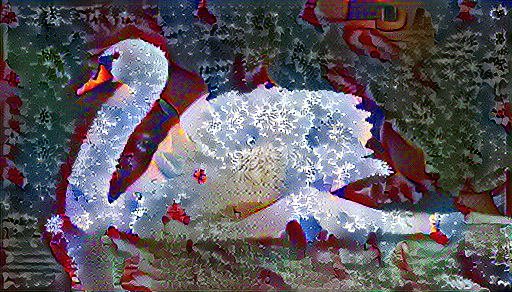

In [54]:
style_weight =  2e-2
content_weight = 1e-2

# define optimizer. learning rate decreases per epoch.
adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=20.0, decay_steps=100, decay_rate=0.50
    )
)

# start the neural style transfer
stylized_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image,
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    optimizer=adam, epochs=10, steps_per_epoch=100)